In [88]:
# pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.8 MB/s 


In [107]:
# Dependencies
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas as hvplot
import plotly as plt
import plotly.express as px

In [2]:
# Read in candidates data
df1 = pd.read_csv("candidates_clean.csv")
df_cand = df1.copy()
df_cand.head()

,Unnamed: 0,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,0,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,L
1,1,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,L
2,2,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,L
3,3,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,L
4,4,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,W


In [4]:
# Read in PAC data 
# df2 = pd.read_csv("pacs.csv", on_bad_lines='skip')
# df_pac = df2.copy()
# df_pac.head()

# Cleaned
# df2 = pd.read_csv('pacs_clean.csv')
# df_pac = df2.copy()
# df_pac.head()

## <font color = 'gold'>Clean

In [5]:
# Handle nulls
# df_pac.isnull().sum()

In [6]:
# df_pac = df_pac.dropna()

In [7]:
# df_pac.duplicated().sum()

In [8]:
# Drop duplicates
# df_pac = df_pac.drop_duplicates()

In [9]:
# df_pac.to_csv('pacs_clean.csv')

In [10]:
# # Join pac and candidates dfs
# df_paccand = df_cand.merge(df_pac, how='left', on='cid')
# df_paccand.head()

## <font color = 'gold'>Explore Features

In [11]:
# See if cycle_candidate is significant
# if there are W and blank c_c, then it's significant
# if there L for every blank c_c, insignificant - drop
# df3 = df_cand[(df_cand['cycle_candidate'] == ' ') & (df_cand['result'] == 'W')]
# df3.head(10)

# KEEP for now, but test both ways.

In [33]:
# Choose columns for features
columns = ['party', 'current_candidate', 'cycle_candidate', 'crpico', 'raised_from_pacs', 'raised_from_individuals',	'raised_total',	'raised_unitemized', 'result']

# # consider dropping later:
#   #cycle_candidate
#   #nopacs
#   #dist_id_currently_held

df_features = df_cand[columns]
df_features.head()

,party,current_candidate,cycle_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,,,C,0.0,6000.0,6000,0.0,L
1,R,,Y,C,492.0,97408.0,264254,166354.0,L
2,R,Y,Y,C,202815.0,618935.0,1636414,814664.0,L
3,U,,,C,0.0,266.0,266,0.0,L
4,R,Y,Y,I,130384.0,99600.0,399980,169996.0,W


In [34]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19863 entries, 0 to 19862
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   party                    19863 non-null  object 
 1   current_candidate        19863 non-null  object 
 2   cycle_candidate          19863 non-null  object 
 3   crpico                   19863 non-null  object 
 4   raised_from_pacs         19863 non-null  float64
 5   raised_from_individuals  19863 non-null  float64
 6   raised_total             19863 non-null  int64  
 7   raised_unitemized        19863 non-null  float64
 8   result                   19863 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.4+ MB


In [35]:
df_features.nunique()

party                          4
current_candidate              2
cycle_candidate                2
crpico                         5
raised_from_pacs           11607
raised_from_individuals    15530
raised_total               17987
raised_unitemized          14653
result                         2
dtype: int64

## <font color = 'gold'>Preprocessing
### Categorical Variables
#### <font color = 'skyblue'>Bucket

In [36]:
for col in df_features.columns:
  print(df_features[col].value_counts())

# drop nopacs, bucket crpico 

R    9746
D    8779
U     786
3     552
Name: party, dtype: int64
Y    12224
      7639
Name: current_candidate, dtype: int64
Y    17737
      2126
Name: cycle_candidate, dtype: int64
C    9506
I    5675
O    4596
       85
3       1
Name: crpico, dtype: int64
0.0         4435
1000.0       343
500.0        243
5000.0       157
2000.0       147
            ... 
570.0          1
421654.0       1
435193.0       1
10098.0        1
345241.0       1
Name: raised_from_pacs, Length: 11607, dtype: int64
 0.0          865
 1000.0       129
 500.0        124
 250.0         64
 200.0         54
             ... 
 5616.0         1
 153472.0       1
 9658.0         1
 1154484.0      1
-127.0          1
Name: raised_from_individuals, Length: 15530, dtype: int64
 500        107
 1000        79
 200         42
 250         41
 300         32
           ... 
 2260         1
 27975        1
 969956       1
 8680358      1
-127          1
Name: raised_total, Length: 17987, dtype: int64
0.0         2977
10

In [37]:
# get value counts variable
crpico_type = df_features['crpico'].value_counts()
crpico_type

C    9506
I    5675
O    4596
       85
3       1
Name: crpico, dtype: int64

In [38]:
# Determine which values to replace if counts are less than 100?
replace_crpico = list(crpico_type[crpico_type < 100].index)

# Replace in dataframe
for cls in replace_crpico:
    df_features.crpico = df_features.crpico.replace(cls,"Other")
    
# Check to make sure binning was successful
df_features.crpico.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


C        9506
I        5675
O        4596
Other      86
Name: crpico, dtype: int64

In [52]:
# encode W/L of 'result' column by mapping
x = {'W': 1, 'L': 0}
df_features = df_features.replace(x)
df_features.head()

,party,current_candidate,cycle_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,,,C,0.0,6000.0,6000,0.0,0
1,R,,Y,C,492.0,97408.0,264254,166354.0,0
2,R,Y,Y,C,202815.0,618935.0,1636414,814664.0,0
3,U,,,C,0.0,266.0,266,0.0,0
4,R,Y,Y,I,130384.0,99600.0,399980,169996.0,1


#### <font color = 'skyblue'>Encode

In [40]:
# generate categorical variable list
catvars = df_features.dtypes[df_features.dtypes == 'object'].index
catvars

Index(['party', 'current_candidate', 'cycle_candidate', 'crpico'], dtype='object')

In [41]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_features[catvars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(catvars)
encode_df.head()

,party_3,party_D,party_R,party_U,current_candidate_,current_candidate_Y,cycle_candidate_,cycle_candidate_Y,crpico_C,crpico_I,crpico_O,crpico_Other
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [42]:
# Merge one-hot encoded features and drop the originals
encoded_df = df_features.merge(encode_df, left_index=True, right_index=True)
encoded_df = encoded_df.drop(catvars, axis=1)
encoded_df.head()

,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result,party_3,party_D,party_R,party_U,current_candidate_,current_candidate_Y,cycle_candidate_,cycle_candidate_Y,crpico_C,crpico_I,crpico_O,crpico_Other
0,0.0,6000.0,6000,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,492.0,97408.0,264254,166354.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,202815.0,618935.0,1636414,814664.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,266.0,266,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,130384.0,99600.0,399980,169996.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


#### <font color= 'skyblue'>Create Features and Target Arrays

In [44]:
# Split preprocessed data into features and target arrays
X = encoded_df.drop('result', axis=1).values
y = df_features.result.values

<font color= 'skyblue'>Split to Training and Testing data

In [49]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

<font color= 'skyblue'>Standard Scale

In [53]:
# Scale / Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# view data to ensure successful standardization
X_train_scaled[:1]

array([[-0.18699866, -0.08465402, -0.12776602, -0.20433232, -0.16801863,
        -0.88741028,  1.01617429, -0.20414555,  1.26663753, -1.26663753,
        -0.34858097,  0.34858097, -0.953872  , -0.63117781,  1.80755599,
        -0.06619982]])

## <font color='gold'>Model - Random Forest Classifier

In [55]:
# Resample the training data with the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=1)

In [66]:
# Calculate the accuracy score
y_true = y_test
y_pred = clf.predict(X_test_scaled)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
print("\n---------------------------------------------------------------------------------\n")


# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Lose", "Win"], columns=["Predicted Lose", "Predicted Win"])
print(cm_df)
print("\n---------------------------------------------------------------------------------\n")

# Print the imbalanced classification report
print(classification_report(y_true, y_pred))

Accuracy Score: 0.9420056383407168

---------------------------------------------------------------------------------

      Predicted Lose  Predicted Win
Lose            3211            163
Win              125           1467

---------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3374
           1       0.90      0.92      0.91      1592

    accuracy                           0.94      4966
   macro avg       0.93      0.94      0.93      4966
weighted avg       0.94      0.94      0.94      4966



## <font color='gold'>KMeans Clustering

In [140]:
# Initialize df from copy
df_clust = df1.copy()
df_clust.head()

,Unnamed: 0,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,0,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,L
1,1,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,L
2,2,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,L
3,3,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,L
4,4,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,W


In [141]:
# isolate first_last_
name = pd.DataFrame(df_clust.first_last_party)
name.head()

,first_last_party
0,Lenora B Fulani (3)
1,Stephen Bonsal Young (R)
2,Raymond J Clatworthy (R)
3,Gavin Terence Mills (I)
4,Ernest J Istook (R)


In [142]:
# Choose features
df_clust = df_clust[['party', 'current_candidate', 'crpico', 'raised_from_pacs',	'raised_from_individuals', 'raised_unitemized']]
df_clust.head()

,party,current_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized
0,3,,C,0.0,6000.0,0.0
1,R,,C,492.0,97408.0,166354.0
2,R,Y,C,202815.0,618935.0,814664.0
3,U,,C,0.0,266.0,0.0
4,R,Y,I,130384.0,99600.0,169996.0


In [143]:
# encode cat variables
X = pd.get_dummies(df_clust, columns=['party','current_candidate','crpico'])
X.head()

,raised_from_pacs,raised_from_individuals,raised_unitemized,party_3,party_D,party_R,party_U,current_candidate_,current_candidate_Y,crpico_,crpico_3,crpico_C,crpico_I,crpico_O
0,0.0,6000.0,0.0,1,0,0,0,1,0,0,0,1,0,0
1,492.0,97408.0,166354.0,0,0,1,0,1,0,0,0,1,0,0
2,202815.0,618935.0,814664.0,0,0,1,0,0,1,0,0,1,0,0
3,0.0,266.0,0.0,0,0,0,1,1,0,0,0,1,0,0
4,130384.0,99600.0,169996.0,0,0,1,0,0,1,0,0,0,1,0


In [144]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)
X_scaled[0:1]

array([[-0.19699569, -0.08959699, -0.10445968,  5.91470165, -0.88996774,
        -0.98149328, -0.2029814 ,  1.26499385, -1.26499385, -0.06555688,
        -0.00709559,  1.0438019 , -0.63244439, -0.54867245]])

### PCA

In [145]:
# Reduce dimensions using PCA
pca = PCA(n_components=3)
cand_pca = pca.fit_transform(X_scaled)

In [146]:
# Create a DataFrame with the three principal components.
pca_df = pd.DataFrame(data=cand_pca, columns=["PC 1", "PC 2", "PC 3"], index=df_clust.index)
pca_df.head(10)

,PC 1,PC 2,PC 3
0,-1.707128,-0.264854,0.346959
1,-2.070208,0.489517,-0.918838
2,0.180680,-0.114178,-1.529005
3,-1.782669,-0.217853,0.392417
4,1.503219,-0.344754,-1.768838
5,-2.086020,0.445173,-0.922577
6,-2.075380,0.474868,-0.920086
7,-1.824110,0.430925,0.678094
8,-2.122460,1.107959,-0.635720
9,-1.473402,-0.024397,1.804401


### Elbow Curve

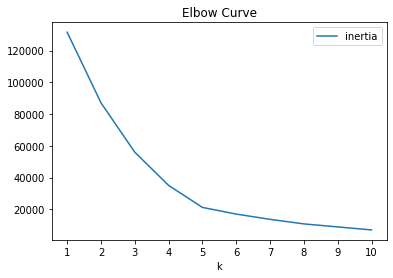

In [147]:
# Create an Elbow Curve to find the best value for K.

inertia = []
k = list(range(1,11))

# Get / store inertia values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)
    
# Define DF to plot Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot(kind='line', x='k', y='inertia', title="Elbow Curve", xticks=k)

Clustering

In [148]:
# Initialize the K-Means model.
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predicts = model.predict(pca_df)

In [149]:
# Create a new DataFrame including predicted clusters and candidate features.
# Concatentate the df_clust and pcs_df DataFrames on the same columns.
clustered_df = df_clust.join(pca_df, how='inner')

#  Add a new column, "CoinName" to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
clustered_df = clustered_df.join(name, how='inner')

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = model.labels_

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(19863, 11)


,party,current_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized,PC 1,PC 2,PC 3,first_last_party,Class
0,3,,C,0.0,6000.0,0.0,-1.707128,-0.264854,0.346959,Lenora B Fulani (3),0
1,R,,C,492.0,97408.0,166354.0,-2.070208,0.489517,-0.918838,Stephen Bonsal Young (R),0
2,R,Y,C,202815.0,618935.0,814664.0,0.180680,-0.114178,-1.529005,Raymond J Clatworthy (R),2
3,U,,C,0.0,266.0,0.0,-1.782669,-0.217853,0.392417,Gavin Terence Mills (I),0
4,R,Y,I,130384.0,99600.0,169996.0,1.503219,-0.344754,-1.768838,Ernest J Istook (R),2
5,R,,C,0.0,5576.0,12474.0,-2.086020,0.445173,-0.922577,Stephen Wayne Hofman (R),0
6,R,,C,2000.0,72177.0,110748.0,-2.075380,0.474868,-0.920086,Olivia Coggin Eudaly (R),0
7,U,,O,0.0,3436.0,1946.0,-1.824110,0.430925,0.678094,H Harold Hardee (I),4
8,R,,O,500.0,40500.0,61320.0,-2.122460,1.107959,-0.635720,Joseph Dr Smith (R),0
9,D,,C,0.0,42841.0,35855.0,-1.473402,-0.024397,1.804401,Godfrey J Dillard (D),4


In [150]:
clustered_df.groupby('Class')['Class'].count()

Class
0    4404
1    5632
2    6604
3       8
4    3215
Name: Class, dtype: int64

In [151]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="first_last_party",
    hover_data=["crpico"],
    width=800
)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()